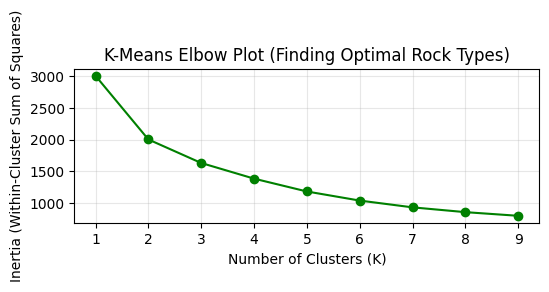

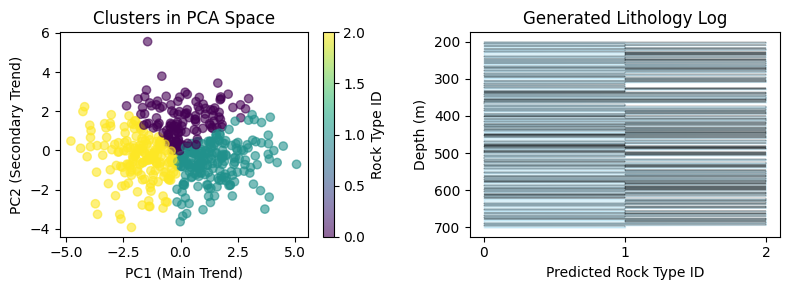


--- Physical Signatures of Each Cluster (Rock Types) ---
          Density      Gamma  Resistivity  Porosity       Sonic    MagSus
Cluster                                                                  
0        2.657238  56.301872    84.402990  0.168550  326.325662  2.310675
1        2.461347  22.995656    62.644341  0.141472  279.701769  0.612315
2        2.941853  47.780995    77.577641  0.029972   68.519364  1.862650


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. GENERATE REALISTIC BOREHOLE DATA (The 6-Sensor Matrix)
np.random.seed(42)
n_samples = 500
depth = np.linspace(200, 700, n_samples)

# Latent geological factors
factor1 = np.random.normal(0, 1, n_samples) # Lithology
factor2 = np.random.normal(0, 1, n_samples) # Mineralization
factor3 = np.random.normal(0, 1, n_samples) # Porosity/Alteration

# Physical Sensors
density = 2.7 + 0.15 * factor1 - 0.2 * factor3 + 0.05 * np.random.randn(n_samples)
gamma_ray = 40 + 20 * factor1 + 5.0 * np.random.randn(n_samples)
resistivity = np.exp(4 - 0.8 * factor2 + 0.2 * np.random.randn(n_samples))
porosity = 0.1 + 0.08 * factor3 + 0.01 * np.random.randn(n_samples)
sonic_time = 200 + 150 * factor3 + 10.0 * np.random.randn(n_samples)
mag_suscept = 1.5 + 1.0 * factor1 + 0.3 * np.random.randn(n_samples)

X = np.column_stack([density, gamma_ray, resistivity, porosity, sonic_time, mag_suscept])
feature_names = ['Density', 'Gamma', 'Resistivity', 'Porosity', 'Sonic', 'MagSus']

# 2. STANDARDIZATION (Critical: K-Means uses Euclidean Distance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. THE ELBOW METHOD (Finding the number of Rock Types)
inertia = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot the Elbow
plt.figure(figsize=(6, 2))
plt.plot(K_range, inertia, marker='o', color='green'); plt.title('K-Means Elbow Plot (Finding Optimal Rock Types)')
plt.xlabel('Number of Clusters (K)'); plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True, alpha=0.3); plt.show()

# 4. RUN K-MEANS WITH OPTIMAL K (Let's assume K=3 based on the factors)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 5. VISUALIZATION (PCA for 2D Projection + Depth Log)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Plot A: PCA Space colored by K-Means
scatter = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
ax[0].set_title("Clusters in PCA Space")
ax[0].set_xlabel("PC1 (Main Trend)"); ax[0].set_ylabel("PC2 (Secondary Trend)")
fig.colorbar(scatter, ax=ax[0], label='Rock Type ID')

# Plot B: The "Lithology" Log (Depth vs Cluster)
ax[1].step(cluster_labels, depth, where='post', color='black', linewidth=0.2)
ax[1].fill_betweenx(depth, cluster_labels, color='skyblue', alpha=0.3)
ax[1].set_title("Generated Lithology Log")
ax[1].set_xlabel("Predicted Rock Type ID"); ax[1].set_ylabel("Depth (m)")
ax[1].invert_yaxis(); ax[1].set_xticks(range(optimal_k))

plt.tight_layout()
plt.show()

# 6. INTERPRETATION: What is the "average" rock for each cluster?
df = pd.DataFrame(X, columns=feature_names)
df['Cluster'] = cluster_labels
print("\n--- Physical Signatures of Each Cluster (Rock Types) ---")
print(df.groupby('Cluster').mean())

Interpreting the "Blockiness" \
When you look at your generated Lithology Log, look for the thickness of the blocks:

Thick Blocks: Indicate a stable geological unit (e.g., 50 meters of solid granite).

Rapid Oscillations: If the log jumps between Cluster 0 and Cluster 1 every few centimeters, it usually means one of two things:\
The "Interbedded" Reality: The rock is actually a sequence of thin layers (like shale and sandstone).\
Sensor Noise: The data is so noisy that the K-Means algorithm is "confused" and keeps flipping between categories.

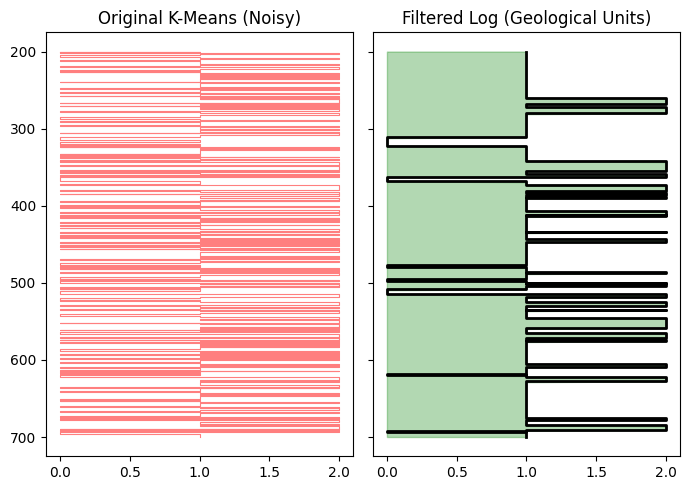

In [16]:
# 1. Convert your clusters to a Pandas Series
cluster_series = pd.Series(cluster_labels)

# 2. Apply a Moving Median Filter 
# window=5 means it looks at 5 neighboring samples
# center=True ensures the data doesn't "shift" downward
cleaned_clusters = cluster_series.rolling(window=7, center=True).median().fillna(method='ffill').fillna(method='bfill')

# 3. Visualize the "Before" vs "After"
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharey=True)

# Original "Noisy" Log
ax[0].step(cluster_labels, depth, where='post', color='red', linewidth=0.8, alpha=0.5)
ax[0].set_title("Original K-Means (Noisy)")
ax[0].invert_yaxis()

# Cleaned "Geological" Log
ax[1].step(cleaned_clusters, depth, where='post', color='black', linewidth=2)
ax[1].fill_betweenx(depth, cleaned_clusters, color='green', alpha=0.3)
ax[1].set_title("Filtered Log (Geological Units)")

plt.tight_layout()
plt.show()

Noise Removal: If a single meter was incorrectly classified as "Cluster 2" in the middle of a 20-meter "Cluster 0" zone, the Median Filter sees it as an outlier and "flattens" it.

Stratigraphy: Your log now shows Massive Units. This is exactly how a geologist interprets a core—they don't log every single pebble; they log the dominant lithology.

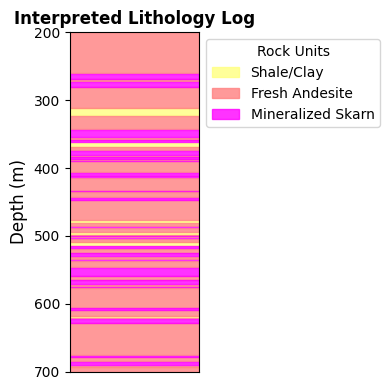

In [22]:
# 1. Define your Geological Legend
# Let's assume based on our physics:
# Cluster 0 = High Gamma/Low Density -> Shale / Clay
# Cluster 1 = Low Gamma/High Density -> Fresh Andesite
# Cluster 2 = Low Resistivity/High Mag -> Mineralized Skarn

geo_map = {
    0: {'name': 'Shale/Clay', 'color': '#FFFF80'},    # Yellow
    1: {'name': 'Fresh Andesite', 'color': '#FF8080'}, # Pink/Light Red
    2: {'name': 'Mineralized Skarn', 'color': '#FF00FF'} # Magenta
}

# 2. Plotting the customized Log
fig, ax = plt.subplots(figsize=(4, 4))

# We loop through each cluster to plot its sections separately
# This allows us to give each one its specific color and label
for cid, info in geo_map.items():
    # Mask to find where this specific cluster exists
    mask = (cleaned_clusters == cid) # the next only works on the i cluster
    
    # We use fill_betweenx to color the blocks
    # 'where' ensures we only fill the parts matching the cluster ID
    ax.fill_betweenx(depth, 0, 1, where=mask, 
                    color=info['color'], label=info['name'], alpha=0.8)

# 3. Formatting the Log
ax.set_ylim(depth.max(), depth.min()) # Invert depth
ax.set_xlim(0, 1) # Keep width constant
ax.set_xticks([]) # Hide the Cluster ID numbers
ax.set_ylabel("Depth (m)", fontsize=12); ax.set_title("Interpreted Lithology Log", fontweight='bold')
# Place the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Rock Units")

plt.tight_layout()
plt.show()

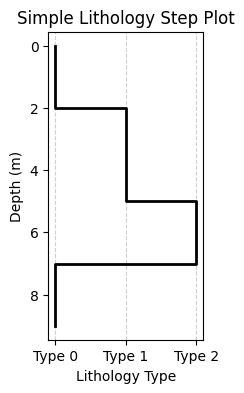

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data: 10 depth points
depth = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Clusters: 0 = Sandstone, 1 = Shale, 2 = Granite
clusters = np.array([0, 0, 0, 1, 1, 1, 2, 2, 0, 0])

plt.figure(figsize=(2, 4))
# The 'step' plot
# 'where' tells the plot where the change happens
plt.step(clusters, depth, where='post', color='black', linewidth=2, label='Rock Boundary')

# Formatting for a borehole look
plt.gca().invert_yaxis()  # Depth 0 at the top
plt.xticks([0, 1, 2], ['Type 0', 'Type 1', 'Type 2'])
plt.xlabel('Lithology Type'); plt.ylabel('Depth (m)')
plt.title('Simple Lithology Step Plot'); plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
